In [1]:
import dask
import dask.array as da
import dask.dataframe as dd
from dask.delayed import delayed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
from shapely import wkt
from datetime import datetime

In [13]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

font = {
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

### Read last 6 years data from the online data portal

In [2]:
url_list  = pd.read_csv('https://data.winnipeg.ca/resource/cymk-nyei.csv', usecols=['url', 'end_date'], parse_dates=['end_date'])
filenames = list(url_list["url"])

# list of dates
dates = list(url_list['end_date'].dt.date)

### Lets calculate the mean delay accross all the routes for each month
_assumptions_:
* Variations at diffenrent times of the day are ignored
* Average is caculated accross all the bus lines

In [3]:
@dask.delayed
def read_file(filename):
    # Read in file
    return pd.read_csv(filename)

mean_dev = []

for fn in filenames:
    # Delayed read in file
    df = read_file(fn)
    
    # Delayed mean
    df_mean_dev = df[['Deviation']].mean()

    # Append to list
    mean_dev.append(df_mean_dev)

# Compute mean
mean_dev = dask.compute(*mean_dev)

/tmp/ipykernel_766491/1795159131.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename)
/tmp/ipykernel_766491/1795159131.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename)
/tmp/ipykernel_766491/1795159131.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename)
/tmp/ipykernel_766491/1795159131.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename)
/tmp/ipykernel_766491/1795159131.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename)
/tmp/ipykernel_766491/1795159131.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd

### Let's plot the mean dealy accross all the routes for each month

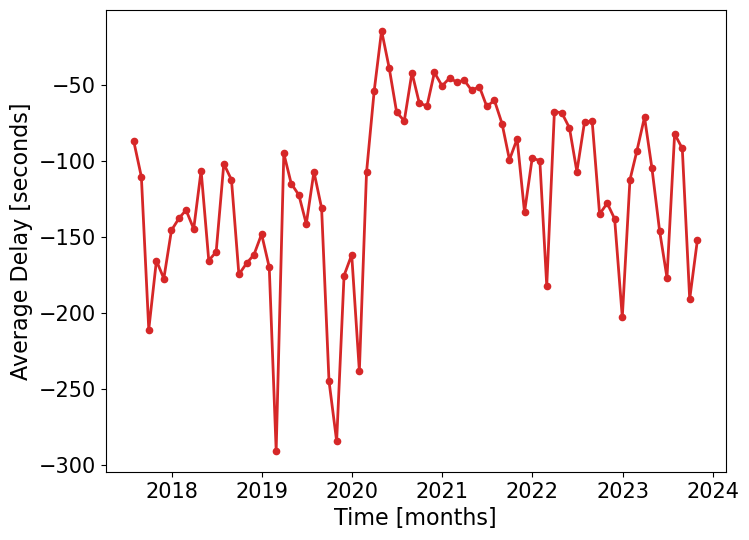

In [17]:
plt.plot(dates, mean_dev, color='tab:red', ls='-', marker='.', linewidth=2, markersize=9)
plt.xlabel('Time [months]')
plt.ylabel('Average Delay [seconds]')
plt.savefig('mean_delay.pdf', dpi=300, bbox_inches='tight')

### Summary
* Winnipeg buses are one average always late
* For last two years, buses are generally 2 minutes late

## Lets check most deyed routes

Lets extract information on delay and route number from the dataset.
We are finding the 10 routes with most delay for each month 

In [19]:
@dask.delayed
def read_file(filename):
    # Read in file
    return pd.read_csv(filename)

late_buses = []

for fn in filenames:
    # Delayed read in file
    df = read_file(fn)
    
    # Delayed mean for each route
    df_mean_dev = df[['Deviation', 'Route Number']].groupby('Route Number').mean()
    df_mean_dev_route = df_mean_dev.sort_values(by=['Deviation'], ascending=True)
    # Append to list
    late_buses.append(df_mean_dev_route.iloc[:10])

# Compute mean
late_buses = dask.compute(*late_buses)

/tmp/ipykernel_766491/2782232107.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename)
/tmp/ipykernel_766491/2782232107.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename)
/tmp/ipykernel_766491/2782232107.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename)
/tmp/ipykernel_766491/2782232107.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename)
/tmp/ipykernel_766491/2782232107.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename)
/tmp/ipykernel_766491/2782232107.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd

In [26]:
for i in range(len(late_buses)):
    late_buses[i]['Route Number'] = late_buses[i].index

In [27]:
# lets get the list of routes
list_of_routes = []
for i in range(len(late_buses)):
    list_of_routes.append(list(late_buses[i]["Route Number"]))

# lets flatted the list of lists
import itertools
list_of_routes_flat = list(itertools.chain(*list_of_routes))

Text(0, 0.5, 'Number of times in top 10 delayed routes')

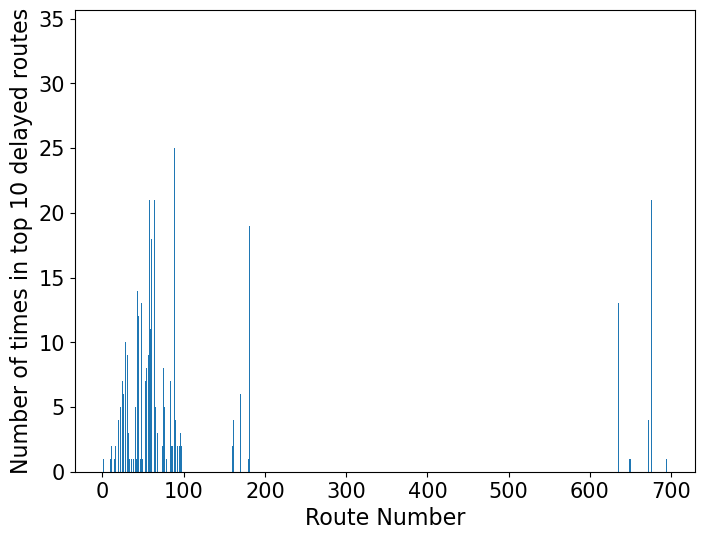

In [44]:
delayed_route_map = {int(x):list_of_routes_flat.count(x) for x in list_of_routes_flat}
plt.bar(delayed_route_map.keys(), delayed_route_map.values())
plt.xlabel('Route Number')
plt.ylabel('Number of times in top 10 delayed routes')

In [45]:
px.bar(x = delayed_route_map.keys(), y = delayed_route_map.values(), labels={'x':'Route Number', 'y':'Number of times in top 10 delayed routes'})
